In [1]:
# load packages
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import networkx as nx
import math, itertools, os, shapely
from shapely.geometry import Polygon, Point

from scipy import ndimage as ndi
from skimage import feature, io
from skimage.transform import rotate
from skimage.feature import match_template, peak_local_max
import cv2
import random
from ortools.linear_solver import pywraplp as OR


In [2]:
CLASSROOMS=[]

In [3]:
buffer=5
Screen_Height=1080 #The Height of Your Physical Screen In Pixels
Screen_Width=1920 #The Width of Your Physical Screen In Pixels
floor = 'BARTON1F.jpg' # you need the path to the image file on YOUR computer
floor2 = 'BARTON1F.jpg' # another image with identifiable distances
solution_name="BARTON-1F-sol"
feetyardStick=20 #how many feet long the yardstick is
floorU = cv2.imread(floor, cv2.IMREAD_UNCHANGED)
floor_str = floor
floor2U = cv2.imread(floor2, cv2.IMREAD_UNCHANGED)
floor2_str = floor2
perimeterft=0.5 #The perimeter space you want to have for chairs from the walls.
x_factor=1 #The frequency with which you want to place chairs in the x direction in a grid pattern. (1 means placing one chair when it ould be 6 feet from the chair before it)
y_factor=1 #The frequency with which you want to place chairs in the y direction in a grid pattern. (1 means placing one chair when it ould be 6 feet from the chair before it)
chairsRandom=300 #The amount of chairs to randomly place. For testing Purposes
chairsRandomHex=0 #The amount of chairs to randomly place in the hexagonal pattern. This allows you to add more chairs than would fit in a hexagonal grid.
x_border = 0 
y_border = 0
desk_border = 0
Shift_Above_Teacher_Zone=True #True tells the code to move all chair placements to start ahead of the teacher.
rotate=False # If True, the defined chair shape will be rotated 90 degrees.
Rotated_Other=False # If True, the chair shape will become an octagon that encompasses all possible rotations of the defined chair.
Scale_Orientation="Vertical" #If "Vertical", will change to define the scale vertically.

In [4]:
if floorU.shape[0] > Screen_Height:
    height=floorU.shape[0]
    Window_Height=Screen_Height
else:
    height=Screen_Height
    Window_Height=floorU.shape[0]-1
if floorU.shape[1]>Screen_Width:
    width=floorU.shape[1]
    Window_Width=Screen_Width
else:
    width=Screen_Width
    Window_Width=floorU.shape[1]-1
NonWritableImage=cv2.imread(floor)
WritableImage=cv2.imread(floor)
Doorways=[]

In [5]:
# get lh, .., uw from full set of 4 coordinates
def getCoords(rect):
    """
    Takes an np.array with coords of rectangle.
    Returns max / min height / width
    """
    lw = min(rect[:,0])
    uw = max(rect[:,0])
    lh = min(rect[:,1])
    uh = max(rect[:,1])

    return(lw, uw, lh, uh)

In [6]:
ref=[]
avger=[]
coords=(0,0)
clone=WritableImage.copy()
cv2.namedWindow("Scale Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Scale Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Scale Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Scale Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
def set_coords(event,x,y,flags,param):
    count=0
    if event==cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Scale Selection"), y+cv2.getTrackbarPos("Hscroll", "Scale Selection")))
        count+=1
    elif event == cv2.EVENT_LBUTTONUP:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Scale Selection"), y+cv2.getTrackbarPos("Hscroll", "Scale Selection")))
        rect = cv2.rectangle(WritableImage, ref[2*count-2], ref[2*count-1], (0, 0, 255), 1)
        cv2.imshow("Scale Selection", rect)
cv2.setMouseCallback("Scale Selection",set_coords)
while True:
    cv2.resizeWindow("Scale Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Scale Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Scale Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Scale Selection", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, refresh image
    if key == ord("r"):
        WritableImage = clone.copy()
        ref=[]
    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break
for r in range(len(ref)//2):
    x1 = ref[2*r][0]
    y1 = ref[2*r][1]
    x2 = ref[2*r+1][0]
    y2 = ref[2*r+1][1]
    if(x1>x2):
        xTemp=x1
        x1=x2
        x2=xTemp
    if(y1>y2):
        yTemp=y1
        y1=y2
        y2=yTemp
    ys = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    avger.append(ys)
x1avg=0
x2avg=0
y1avg=0
y2avg=0
for ys in avger:
    x1avg+=ys[0][0]
    x2avg+=ys[1][0]
    y1avg+=ys[0][1]
    y2avg+=ys[2][1]
x1avg=x1avg/len(avger)
x2avg=x2avg/len(avger)
y1avg=y1avg/len(avger)
y2avg=y2avg/len(avger)
print(x2avg)
print(x1avg)
print(y2avg)
print(y1avg)
if Scale_Orientation=="Vertical":
    Temp1=x1avg
    x1avg=y1avg
    y1avg=Temp1
    Temp2=x2avg
    x2avg=y2avg
    y2avg=Temp2
print(y2avg)
print(y1avg)
print(x2avg)
print(x1avg)

stick_points=np.array([(x1avg,y1avg),(x2avg,y1avg),(x2avg,y2avg),(x1avg,y2avg)])
Stick=Polygon(stick_points)
feet6=6.0/feetyardStick*(x2avg-x1avg)
feet10=5/3*feet6
print(str(feetyardStick)+' feet = %d pixels.' % (x2avg-x1avg))
print(' 6 feet = %.1f pixels' % feet6)

233.0
224.0
2575.0
2455.0
233.0
224.0
2575.0
2455.0
20 feet = 120 pixels.
 6 feet = 36.0 pixels


In [7]:
#Check Scale
cv2.namedWindow("ScaleCheck",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("ScaleCheck",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
CheckPoints=[]
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "ScaleCheck", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "ScaleCheck", scrollWidth, (width-Screen_Width),TrackbarChange)
ref = []
def get_coords(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "ScaleCheck"), y+cv2.getTrackbarPos("Hscroll", "ScaleCheck")))
        print((x,y))
        door=cv2.circle(WritableImage,ref[-1],int(feet6/2),(0,255,0),1,1)
        cv2.imshow("ScaleCheck", door)
cv2.setMouseCallback("ScaleCheck", get_coords)
while True:
    cv2.resizeWindow("ScaleCheck", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "ScaleCheck")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "ScaleCheck")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("ScaleCheck", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break
CheckPoints=ref


(771, 486)


In [8]:
ref=[]
avger=[]
refresh=[]
coords=(0,0)
WritableClone=WritableImage.copy()
cv2.namedWindow("Classroom Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Classroom Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
xmin=99999
xmax=0
ymin=99999
ymax=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Classroom Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Classroom Selection", scrollWidth, (width-Screen_Width),TrackbarChange)

def set_coords(event,x,y,flags,param):
    count=0
    if event==cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Classroom Selection"), y+cv2.getTrackbarPos("Hscroll", "Classroom Selection")))
        refresh.append('r')
    if event==cv2.EVENT_RBUTTONDOWN:
        del ref[-1]
        refresh.append('r')

cv2.setMouseCallback("Classroom Selection",set_coords)

while True:
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Classroom Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Classroom Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Classroom Selection", Image)
    
    if len(refresh)>=1:
        WritableImage=WritableClone.copy()
        
        for point in ref:
            if point[0]<=xmin:
                xmin=point[0]
            if point[1]<=ymin:
                ymin=point[1]
            if point[0]>=xmax:
                xmax=point[0]
            if point[1]>=ymax:
                ymax=point[1]
        
        cv2.rectangle(WritableImage, (xmin, ymin), (xmax,ymax), (255,0,0), 1)
        refresh=[]
    
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, restart
    if key == ord("r"):
        ref=[]
        xmin=99999
        xmax=0
        ymin=99999
        ymax=0
        refresh.append('r')
    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break

Classroom = np.array([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
x_edge=(xmin,xmax)
y_edge=(ymin,ymax)
WritableImage=WritableClone.copy()
rect = cv2.rectangle(WritableImage, (xmin, ymin), (xmax,ymax), (255,0,0), 1)

In [10]:
ref=[]
avger=[]
coords=(0,0)
clone=WritableImage.copy()
cv2.namedWindow("Chair Selection",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Chair Selection",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Chair Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Chair Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
def set_coords(event,x,y,flags,param):
    count=0
    if event==cv2.EVENT_LBUTTONDOWN:
        if Rotated_Other!=True:
            if len(ref)<2:
                ref.append((x+cv2.getTrackbarPos("Wscroll", "Chair Selection"), y+cv2.getTrackbarPos("Hscroll", "Chair Selection")))
                count+=1
        else:
            ref.append((x+cv2.getTrackbarPos("Wscroll", "Chair Selection"), y+cv2.getTrackbarPos("Hscroll", "Chair Selection")))
    elif event == cv2.EVENT_LBUTTONUP:
        if(len(ref)==2):
            if Rotated_Other!=True:
                rect = cv2.rectangle(WritableImage, ref[2*count-2], ref[2*count-1], (0, 0, 255), 1)
                cv2.imshow("Chair Selection", rect)
                print(ref)
        circ=cv2.circle(WritableImage, ref[-1], 2, (0,0,255), 2)
        cv2.imshow("Chair Selection", circ)
cv2.setMouseCallback("Chair Selection",set_coords)
while True:
    cv2.resizeWindow("Chair Selection", Window_Width, Window_Height)
    scrollHeight=cv2.getTrackbarPos("Hscroll", "Chair Selection")
    scrollWidth=cv2.getTrackbarPos("Wscroll", "Chair Selection")
    ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Chair Selection", Image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, refresh image
    if key == ord("r"):
        WritableImage = clone.copy()
        ref=[]
    # if the 'e' key is pressed, break from the loop
    elif key == ord("e"):
        cv2.destroyAllWindows()
        break
if Rotated_Other!=True:
    for r in range(len(ref)//2):
        x1 = ref[2*r][0]
        y1 = ref[2*r][1]
        x2 = ref[2*r+1][0]
        y2 = ref[2*r+1][1]
        if(x1>x2):
            xTemp=x1
            x1=x2
            x2=xTemp
        if(y1>y2):
            yTemp=y1
            y1=y2
            y2=yTemp
        Chair = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
    if rotate == True:
        temp1 = x1
        x1 = y1
        y1 = temp1
        temp2 = x2
        x2 = y2
        y2 = temp2
    Polygon_Width=x2-x1
    Polygon_Height=y2-y1
    arr = np.array([(-int(Polygon_Width/2),-int(Polygon_Height/2)), (-int(Polygon_Width/2),int(Polygon_Height/2)),(int(Polygon_Width/2),int(Polygon_Height/2)),(int(Polygon_Width/2),-int(Polygon_Height/2))])
if Rotated_Other==True:
    diameter=-1
    for point in ref:
        for point2 in ref:
            TempDiameter=((point2[0]-point[0])**2+(point2[1]-point[1])**2)**0.5
            if TempDiameter>diameter:
                diameter=TempDiameter
    angle=math.radians(22.5)
    arr=np.array([(-diameter/2*math.tan(angle),diameter/2),(diameter/2*math.tan(angle),diameter/2),(diameter/2,diameter/2*math.tan(angle)),(diameter/2,-diameter/2*math.tan(angle)),(diameter/2*math.tan(angle),-diameter/2),(-diameter/2*math.tan(angle),-diameter/2),(-diameter/2,-diameter/2*math.tan(angle)),(-diameter/2, diameter/2*math.tan(angle))])
    Polygon_Width=diameter+1
    Polygon_Height=diameter+1
print(arr)
p = Polygon(arr)
WritableImage=clone.copy()
rect = cv2.rectangle(WritableImage, ref[0], ref[1], (0, 0, 255), 1)

[(1271, 511), (1285, 525)]
[[-7 -7]
 [-7  7]
 [ 7  7]
 [ 7 -7]]


In [11]:
placlist=[4,5,6,7,8,9,10,13]
dimensions=[]

for colplac in placlist:
    chairplac=math.ceil(50/colplac)
    widthft=math.ceil((colplac-1)*(feet6+Polygon_Width/2+1)+Polygon_Width+buffer*feet6/3+2)
    heightft=math.ceil((chairplac-1)*(feet6+Polygon_Height/2+1)+Polygon_Height+buffer*feet6/3+2)
    if widthft<heightft:
        heightft=math.ceil(heightft+feet6*5/3+1)
        t_box_pos="vertical"
    else:
        widthft=math.ceil(widthft+feet6*5/3+1)
        t_box_pos="horizontal"
    dimensions.append([widthft,heightft,t_box_pos])
print(dimensions)


[[208, 665, 'vertical'], [252, 533, 'vertical'], [296, 489, 'vertical'], [340, 445, 'vertical'], [445, 340, 'horizontal'], [489, 296, 'horizontal'], [533, 252, 'horizontal'], [665, 208, 'horizontal']]


In [12]:
#Define the Polygon
cv2.namedWindow("Classroom Placement",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Classroom Placement",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
selection=0
classroomTypes=len(dimensions)-1
WritableClone=WritableImage.copy()
ref = []
refTemp=[]
refresh=[]
t_zone_orientation=[]

def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Classroom Placement", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Classroom Placement", scrollWidth, (width-Screen_Width),TrackbarChange)

def get_coords(event, x, y, flags, param):
    count = 0
    if event == cv2.EVENT_MOUSEMOVE:
        for item in range(len(refTemp)):
            del refTemp[-1]
        refTemp.append((x+cv2.getTrackbarPos("Wscroll", "Classroom Placement"), y+cv2.getTrackbarPos("Hscroll", "Classroom Placement")))
        refTemp.append((int(refTemp[0][0]+dimensions[selection][0]), int(refTemp[0][1]+dimensions[selection][1])))
        refresh.append('r')
    if event == cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Classroom Placement"), y+cv2.getTrackbarPos("Hscroll", "Classroom Placement")))
        ref.append((int(ref[-1][0]+dimensions[selection][0]), int(ref[-1][1]+dimensions[selection][1])))
        refresh.append('r')
        t_zone_orientation.append(dimensions[selection][2])
    elif event==cv2.EVENT_RBUTTONDOWN:
        del ref[-1]
        del ref[-1]
        del t_zone_orientation[-1]
        refresh.append('r')

cv2.setMouseCallback("Classroom Placement", get_coords)

while True:
    
    #These lines are what allow the scrolling
    ScrollHeight=cv2.getTrackbarPos("Hscroll", "Classroom Placement")
    ScrollWidth=cv2.getTrackbarPos("Wscroll", "Classroom Placement")
    ShownImage = np.array([(ScrollWidth,ScrollHeight),(ScrollWidth+width,ScrollHeight),(ScrollWidth+width,ScrollHeight+height),(ScrollWidth,ScrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Classroom Placement", Image)
    
    #Refreshes the polygon on the image if there has been an update to it
    if len(refresh)>=1:
        WritableImage=WritableClone.copy()
        if len(ref)>=2:
            for i in range(len(ref)//2):
                cv2.rectangle(WritableImage,ref[i*2],ref[i*2+1],(255, 0, 255), 1)
                cv2.rectangle(WritableImage,(int(ref[i*2][0]+buffer*feet6/6),int(ref[i*2][1]+buffer*feet6/6)),(int(ref[i*2+1][0]-buffer*feet6/6),int(ref[i*2+1][1]-buffer*feet6/6)),(255,0,255),1)
        if len(refTemp)==2:
            cv2.rectangle(WritableImage, refTemp[0],refTemp[1],(0,255,0),1)
            cv2.rectangle(WritableImage,(int(refTemp[0][0]+buffer*feet6/6),int(refTemp[0][1]+buffer*feet6/6)),(int(refTemp[1][0]-buffer*feet6/6),int(refTemp[1][1]-buffer*feet6/6)),(0,2),1)
        refresh=[]
    
    #Listen for key presses
    key = cv2.waitKey(1) & 0xFF
    
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break

    # if the key 'd' is pressed, completely delete the polygon being worked on.
    if key==ord("d"):
        if selection<classroomTypes:
            selection=selection+1
        else:
            selection=0
    if key==ord("a"):
        if selection>0:
            selection=selection-1
        else:
            selection=classroomTypes
WritableImage=WritableClone.copy()

In [13]:
#Define the Polygon
cv2.namedWindow("Irregular Classroom Placement",cv2.WINDOW_AUTOSIZE)
cv2.resizeWindow("Irregular Classroom Placement",Window_Width, Window_Height)
scrollHeight=0
scrollWidth=0
WritableClone=WritableImage.copy()
refTemp=[]
refresh=[]
refInitial=len(ref)

def TrackbarChange(integer):
    return
cv2.createTrackbar("Hscroll", "Irregular Classroom Placement", scrollHeight, (height-Screen_Height),TrackbarChange)
cv2.createTrackbar("Wscroll", "Irregular Classroom Placement", scrollWidth, (width-Screen_Width),TrackbarChange)

def get_coords(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        for item in range(len(refTemp)):
            del refTemp[-1]
        refTemp.append((x+cv2.getTrackbarPos("Wscroll", "Irregular Classroom Placement"), y+cv2.getTrackbarPos("Hscroll", "Irregular Classroom Placement")))
        refresh.append('r')
    if event == cv2.EVENT_LBUTTONDOWN:
        ref.append((x+cv2.getTrackbarPos("Wscroll", "Irregular Classroom Placement"), y+cv2.getTrackbarPos("Hscroll", "Irregular Classroom Placement")))
        refresh.append('r')
    elif event==cv2.EVENT_RBUTTONDOWN:
        if len(ref)>refInitial:
            del ref[-1]
            refresh.append('r')
cv2.setMouseCallback("Irregular Classroom Placement", get_coords)

while True:
    
    #These lines are what allow the scrolling
    ScrollHeight=cv2.getTrackbarPos("Hscroll", "Irregular Classroom Placement")
    ScrollWidth=cv2.getTrackbarPos("Wscroll", "Irregular Classroom Placement")
    ShownImage = np.array([(ScrollWidth,ScrollHeight),(ScrollWidth+width,ScrollHeight),(ScrollWidth+width,ScrollHeight+height),(ScrollWidth,ScrollHeight+height)])
    cds = getCoords(ShownImage)
    Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
    cv2.imshow("Irregular Classroom Placement", Image)
    
    #Refreshes the polygon on the image if there has been an update to it
    if len(refresh)>=1:
        WritableImage=WritableClone.copy()
        if len(ref)>=2:
            for i in range((len(ref)-(len(ref)%2))//2):
                cv2.rectangle(WritableImage,ref[i*2],ref[i*2+1],(255, 0, 255), 1)
        if len(ref)%2==1:
            cv2.rectangle(WritableImage,ref[-1],refTemp[0],(0,255,0),1)
        refresh=[]
    
    #Listen for key presses
    key = cv2.waitKey(1) & 0xFF
    
    # if the 'e' key is pressed, break from the loop
    if key == ord("e"):
        cv2.destroyAllWindows()
        break

    # if the key 'd' is pressed, completely delete the polygon being worked on.
    if key==ord("d"):
        if selection<classroomTypes:
            selection=selection+1
        else:
            selection=0
    if key==ord("a"):
        if selection>0:
            selection=selection-1
        else:
            selection=classroomTypes
for i in range((len(ref)-refInitial)//2):
    t_zone_orientation.append('irregular')
for i in range(len(ref)//2):
    classroom={}
    classroom['position']=[ref[i*2],ref[i*2+1]]
    classroom['t_box_orientation']=t_zone_orientation[i]
    CLASSROOMS.append(classroom)
    
print(CLASSROOMS)
WritableImage=WritableClone.copy()
if len(ref)>=2:
    for i in range((len(ref)-(len(ref)%2))//2):
        cv2.rectangle(WritableImage,ref[i*2],ref[i*2+1],(255, 0, 255), 1)

[{'position': [(730, 536), (1175, 876)], 't_box_orientation': 'horizontal'}, {'position': [(730, 876), (1175, 1216)], 't_box_orientation': 'horizontal'}, {'position': [(730, 1216), (1175, 1556)], 't_box_orientation': 'horizontal'}, {'position': [(730, 1556), (1175, 1896)], 't_box_orientation': 'horizontal'}, {'position': [(730, 1896), (1175, 2236)], 't_box_orientation': 'horizontal'}, {'position': [(1201, 536), (1541, 981)], 't_box_orientation': 'vertical'}, {'position': [(1520, 593), (1816, 1082)], 't_box_orientation': 'vertical'}, {'position': [(1520, 1082), (1816, 1571)], 't_box_orientation': 'vertical'}, {'position': [(1520, 1571), (1816, 2060)], 't_box_orientation': 'vertical'}, {'position': [(1520, 2060), (1816, 2549)], 't_box_orientation': 'vertical'}, {'position': [(1201, 981), (1541, 1426)], 't_box_orientation': 'vertical'}, {'position': [(1201, 1426), (1541, 1871)], 't_box_orientation': 'vertical'}, {'position': [(1201, 1871), (1541, 2316)], 't_box_orientation': 'vertical'}, 

In [14]:
print(t_zone_orientation)

['horizontal', 'horizontal', 'horizontal', 'horizontal', 'horizontal', 'vertical', 'vertical', 'vertical', 'vertical', 'vertical', 'vertical', 'vertical', 'vertical', 'irregular', 'irregular']


In [15]:
for classroom in CLASSROOMS:
    classroom['position'][0]=(int(classroom['position'][0][0]+buffer*feet6/6),int(classroom['position'][0][1]+buffer*feet6/6))
    classroom['position'][1]=(int(classroom['position'][1][0]-buffer*feet6/6),int(classroom['position'][1][1]-buffer*feet6/6))

In [16]:
#Define the Polygon
WritableImage=NonWritableImage.copy()
for classroom in CLASSROOMS:
    cv2.namedWindow("Doorway Selection",cv2.WINDOW_AUTOSIZE)
    cv2.resizeWindow("Doorway Selection",Window_Width, Window_Height)
    scrollHeight=0
    scrollWidth=0
    WritableClone=WritableImage.copy()
    ref = []
    refresh=[]
    Doorways=[]
    def TrackbarChange(integer):
        return
    cv2.rectangle(WritableImage,classroom['position'][0],classroom['position'][1],(0,255,0),1)
    cv2.createTrackbar("Hscroll", "Doorway Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
    cv2.createTrackbar("Wscroll", "Doorway Selection", scrollWidth, (width-Screen_Width),TrackbarChange)

    def get_coords(event, x, y, flags, param):
        count = 0
        if event == cv2.EVENT_LBUTTONDOWN:
            ref.append((x+cv2.getTrackbarPos("Wscroll", "Doorway Selection"), y+cv2.getTrackbarPos("Hscroll", "Doorway Selection")))
            refresh.append('r')
        elif event==cv2.EVENT_RBUTTONDOWN:
            del ref[-1]
            refresh.append('r')

    cv2.setMouseCallback("Doorway Selection", get_coords)

    while True:
    
        #These lines are what allow the scrolling
        ScrollHeight=cv2.getTrackbarPos("Hscroll", "Doorway Selection")
        ScrollWidth=cv2.getTrackbarPos("Wscroll", "Doorway Selection")
        ShownImage = np.array([(ScrollWidth,ScrollHeight),(ScrollWidth+width,ScrollHeight),(ScrollWidth+width,ScrollHeight+height),(ScrollWidth,ScrollHeight+height)])
        cds = getCoords(ShownImage)
        Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
        cv2.imshow("Doorway Selection", Image)
    
        #Refreshes the polygon on the image if there has been an update to it
        if len(refresh)>=1:
            WritableImage=WritableClone.copy()
            if len(ref)>=2:
                for i in range(len(ref)):
                    cv2.line(WritableImage,ref[i],ref[i-1],(255, 0, 255), 1)
            elif len(ref)==1:
                cv2.circle(WritableImage,ref[0],2,(255,0,255),2)
            refresh=[]
            cv2.rectangle(WritableImage,classroom['position'][0],classroom['position'][1],(0,255,0),1)
    
        #Listen for key presses
        key = cv2.waitKey(1) & 0xFF
    
        # if the 'e' key is pressed, break from the loop
        if key == ord("e"):
            cv2.rectangle(WritableImage,classroom['position'][0],classroom['position'][1],(255,0,255),1)
            cv2.destroyAllWindows()
            break
        
        # if the key 'f' is pressed, finalize the polygon and get ready to make a new one
        if key==ord("f") and len(ref)>=3:
            Doorway=np.array(ref)
            doorway = Polygon(Doorway)
            Doorways.append(doorway)
            for item in range(len(ref)):
                del ref[-1]
            WritableClone=WritableImage.copy()
    
        # if the key 'd' is pressed, completely delete the polygon being worked on.
        if key==ord("d"):
            for item in range(len(ref)):
                del ref[-1]
            refresh.append('r')
    classroom['doorways']=(Doorways)




In [17]:
#Define the teacher area
t_boxes=['top','right','bottom','left']
selection=0
for classroom in CLASSROOMS:
    cv2.namedWindow("Teacher Box Selection",cv2.WINDOW_AUTOSIZE)
    cv2.resizeWindow("Teacher Box Selection",Window_Width, Window_Height)
    scrollHeight=0
    scrollWidth=0
    positions=[]
    def TrackbarChange(integer):
        return
    cv2.createTrackbar("Hscroll", "Teacher Box Selection", scrollHeight, (height-Screen_Height),TrackbarChange)
    cv2.createTrackbar("Wscroll", "Teacher Box Selection", scrollWidth, (width-Screen_Width),TrackbarChange)
    ref = []
    cv2.rectangle(WritableImage,classroom['position'][0],classroom['position'][1],(0,255,0),1)
    def get_coords(event, x, y, flags, param):
        count = 0
        if event == cv2.EVENT_LBUTTONDOWN:
            if ref != []:
                for item in range(len(ref)):
                    del ref[-1]
            ref.append((x+cv2.getTrackbarPos("Wscroll", "Teacher Box Selection"), y+cv2.getTrackbarPos("Hscroll", "Teacher Box Selection")))
            
            if classroom['t_box_orientation']=='vertical':
                if selection%2==0:#'top'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((int(temp[0]-feet6),classroom['position'][0][1]))
                    ref.append((int(temp[0]+feet6),int(classroom['position'][0][1]+feet10)))
                    positions.append('top')
                else:#'bottom'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((int(temp[0]-feet6),int(classroom['position'][1][1]-feet10)))
                    ref.append((int(temp[0]+feet6),classroom['position'][1][1]))
                    positions.append('bottom')
            elif classroom['t_box_orientation']=='horizontal':
                if selection%2==0:#'left'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((classroom['position'][0][0],int(temp[1]-feet6)))
                    ref.append((int(classroom['position'][0][0]+feet10),int(temp[1]+feet6)))
                    positions.append('left')
                else:#'right'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((int(classroom['position'][1][0]-feet10),int(temp[1]-feet6)))
                    ref.append((classroom['position'][1][0],int(temp[1]+feet6)))
                    positions.append('right')
            else:#'irregular'
                if selection%4==0:#'top'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((int(temp[0]-feet6),classroom['position'][0][1]))
                    ref.append((int(temp[0]+feet6),int(classroom['position'][0][1]+feet10)))
                    positions.append('top')
                elif selection%4==1:#'right'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((int(classroom['position'][1][0]-feet10),int(temp[1]-feet6)))
                    ref.append((classroom['position'][1][0],int(temp[1]+feet6)))
                    positions.append('right')
                elif selection%4==2:#'bottom'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((int(temp[0]-feet6),int(classroom['position'][1][1]-feet10)))
                    ref.append((int(temp[0]+feet6),classroom['position'][1][1]))
                    positions.append('bottom')
                else:#'left'
                    temp=ref[0]
                    del ref[-1]
                    ref.append((classroom['position'][0][0],int(temp[1]-feet6)))
                    ref.append((int(classroom['position'][0][0]+feet10),int(temp[1]+feet6)))
                    positions.append('left')
            rect = cv2.rectangle(WritableImage, ref[0], ref[1], (255, 0, 0), 1)
            cv2.imshow("Teacher Box Selection", rect)
   
    cv2.setMouseCallback("Teacher Box Selection", get_coords)
    
    while True:
        cv2.resizeWindow("Teacher Box Selection", Window_Width, Window_Height)
        scrollHeight=cv2.getTrackbarPos("Hscroll", "Teacher Box Selection")
        scrollWidth=cv2.getTrackbarPos("Wscroll", "Teacher Box Selection")
        ShownImage = np.array([(scrollWidth,scrollHeight),(scrollWidth+width,scrollHeight),(scrollWidth+width,scrollHeight+height),(scrollWidth,scrollHeight+height)])
        cds = getCoords(ShownImage)
        Image = WritableImage[cds[2]:cds[3], cds[0]:cds[1]]
        cv2.imshow("Teacher Box Selection", Image)
        key = cv2.waitKey(1) & 0xFF
        # if the 'e' key is pressed, break from the loop
        if key == ord("e"):
            cv2.rectangle(WritableImage,classroom['position'][0],classroom['position'][1],(255,0,255),1)
            cv2.destroyAllWindows()
            break
        if key==ord("d"):
            selection=selection+1
        if key==ord("a"):
            selection=selection-1
    nogozone = np.array([ref[0], (ref[0][0], ref[1][1]), ref[1], (ref[1][0], ref[0][1])])
    classroom['nogozone']=nogozone
    zone = Polygon(nogozone)
    classroom['zone']=zone
    classroom['t_box_side']=positions[-1]


In [18]:
print(CLASSROOMS)

[{'position': [(760, 566), (1145, 846)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[760, 668],
       [760, 740],
       [820, 740],
       [820, 668]]), 'zone': <shapely.geometry.polygon.Polygon object at 0x0000017DACB77488>, 't_box_side': 'left'}, {'position': [(760, 906), (1145, 1186)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[ 760, 1014],
       [ 760, 1086],
       [ 820, 1086],
       [ 820, 1014]]), 'zone': <shapely.geometry.polygon.Polygon object at 0x0000017DACB77C88>, 't_box_side': 'left'}, {'position': [(760, 1246), (1145, 1526)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[ 760, 1346],
       [ 760, 1418],
       [ 820, 1418],
       [ 820, 1346]]), 'zone': <shapely.geometry.polygon.Polygon object at 0x0000017DACB91448>, 't_box_side': 'left'}, {'position': [(760, 1586), (1145, 1866)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[ 760, 1693],
       [ 760, 1765],
  

In [19]:
for classroom in CLASSROOMS:
    if Shift_Above_Teacher_Zone:
        print("Shift")
        if classroom['t_box_side'] == 'top':
            classroom['position'][0]=(classroom['position'][0][0],classroom['nogozone'][1][1])
        elif classroom['t_box_side'] == 'bottom':
            classroom['position'][1]=(classroom['position'][1][0],classroom['nogozone'][0][1])
        elif classroom['t_box_side'] == 'left':
            classroom['position'][0]=(classroom['nogozone'][2][0],classroom['position'][0][1])
        elif classroom['t_box_side'] == 'right':
            classroom['position'][1]=(classroom['nogozone'][0][0],classroom['position'][1][1])

Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift
Shift


In [20]:
print(CLASSROOMS)

[{'position': [(820, 566), (1145, 846)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[760, 668],
       [760, 740],
       [820, 740],
       [820, 668]]), 'zone': <shapely.geometry.polygon.Polygon object at 0x0000017DACB77488>, 't_box_side': 'left'}, {'position': [(820, 906), (1145, 1186)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[ 760, 1014],
       [ 760, 1086],
       [ 820, 1086],
       [ 820, 1014]]), 'zone': <shapely.geometry.polygon.Polygon object at 0x0000017DACB77C88>, 't_box_side': 'left'}, {'position': [(820, 1246), (1145, 1526)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[ 760, 1346],
       [ 760, 1418],
       [ 820, 1418],
       [ 820, 1346]]), 'zone': <shapely.geometry.polygon.Polygon object at 0x0000017DACB91448>, 't_box_side': 'left'}, {'position': [(820, 1586), (1145, 1866)], 't_box_orientation': 'horizontal', 'doorways': [], 'nogozone': array([[ 760, 1693],
       [ 760, 1765],
  

In [21]:

shape =4
if Rotated_Other==True:
    shape=8
for classroom in CLASSROOMS:
    classroom['locs']=list()
    classroom['polys'] = list()
    classroom['points'] = list()
    Chairs_x=int((classroom['position'][1][0]-classroom['position'][0][0]-Polygon_Width)//((feet6+Polygon_Width/2+1)/x_factor)+1)
    Chairs_y=int((classroom['position'][1][1]-classroom['position'][0][1]-Polygon_Height)//((feet6+Polygon_Height/2+1)/y_factor)+1)
    print((Chairs_x,Chairs_y))
    if classroom['t_box_side']=='top' or classroom['t_box_side']=='left':
        for column in range(Chairs_x):
            for chair in range(Chairs_y):
                classroom['locs'].append((classroom['position'][0][0]+Polygon_Width/2+((feet6+Polygon_Width/2+1)/x_factor)*column+1,classroom['position'][0][1]+Polygon_Height/2+((feet6+Polygon_Height/2+1)/y_factor)*chair+1))
    else:
        for column in range(Chairs_x):
            for chair in range(Chairs_y):
                classroom['locs'].append((classroom['position'][1][0]-Polygon_Width/2-((feet6+Polygon_Width/2+1)/x_factor)*column-1,classroom['position'][1][1]-Polygon_Height/2-((feet6+Polygon_Height/2+1)/y_factor)*chair-1))
    for i in range(len(classroom['locs'])):
        classroom['polys'].append(Polygon(arr + np.array([classroom['locs'][i]]*shape)))
        classroom['points'].append(Point(np.array([0, 0] + np.array([classroom['locs'][i][0], classroom['locs'][i][1]]))))

(8, 7)
(8, 7)
(8, 7)
(8, 7)
(8, 7)
(7, 8)
(6, 9)
(6, 9)
(6, 9)
(6, 9)
(7, 8)
(7, 8)
(7, 8)
(8, 8)
(6, 5)


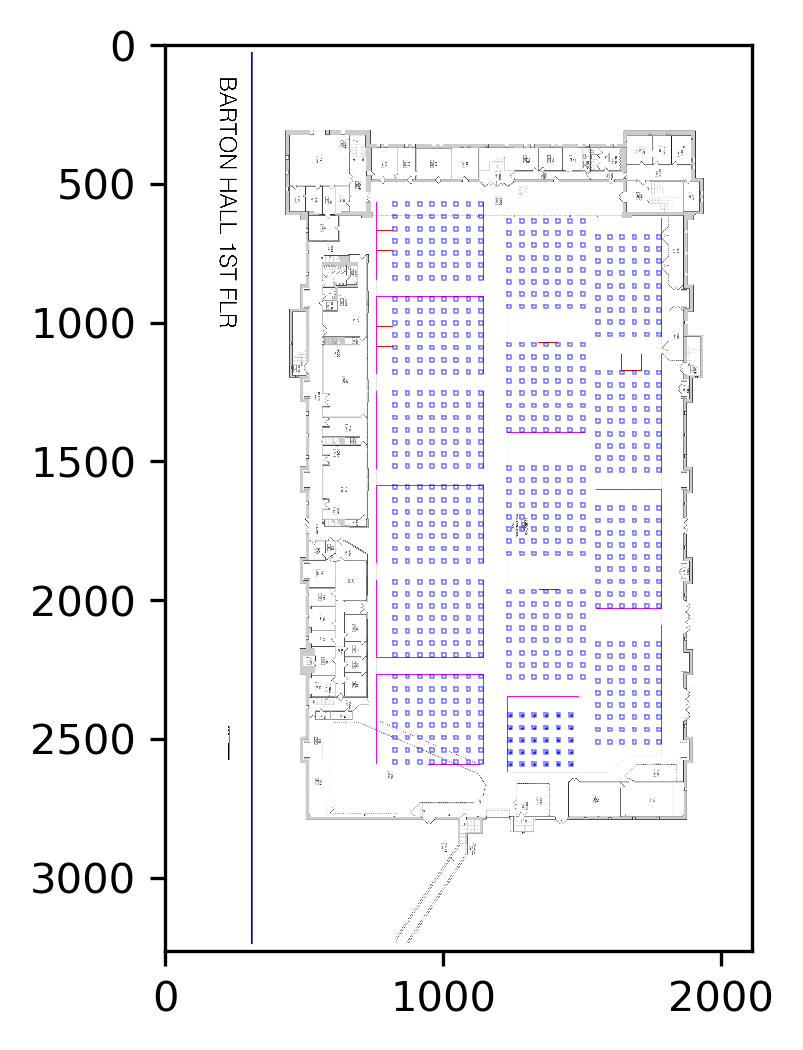

In [22]:
# plot solutions (airline seat booking style)
img = WritableImage
fig, ax = plt.subplots(dpi=300)
for classroom in CLASSROOMS:
    for i in range(len(classroom['polys'])):
        x,y = classroom['polys'][i].exterior.xy
        ax.plot(x, y, color='blue', alpha=0.5, linewidth=0.4, solid_capstyle='round', zorder=2)
    
# plot points    
xs = [point.x for point in classroom['points']]
ys = [point.y for point in classroom['points']]
plt.scatter(xs, ys, s=0.1, color='blue', alpha=1, linewidth=0.3)

ax.imshow(img)

In [23]:
# a model for counting seats (function by Jody Zhu)

# 'nodes' is a list of chairs, 'edges' is a list of (chair,chair) tuples that are too close
def miset(nodes,edges,solver):
    NODES = []
    NODES.extend(nodes)    # these four lines are not necessary
    EDGES = []             # made a copy in case the lists will be modified
    EDGES.extend(edges)
    
    # define model
    m = OR.Solver('maxIndSet', solver)
    
    # decision variables
    x = {} # node i is in the maximal independent set is 1, else 0
    for i in NODES:
        x[i] = m.IntVar(0, 1, ('%s' % (i))) 
        
    # objective function
    m.Maximize(sum(x[i] for i in NODES))
        
    # subject to: no more than 1 node from an edge
    for edge in EDGES:
        m.Add(x[edge[0]] + x[edge[1]] <= 1)

    m.Solve()
    
    sol = {}
    for i in NODES:
        sol.update( {x[i].name() : x[i].solution_value()} )

    print('Total seats:', m.Objective().Value())
    
    return(sol)

There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 54 nodes.
There are 0 edges and 54 nodes.
Total seats: 54.0
There are 54 nodes.
There are 0 edges and 54 nodes.
Total seats: 54.0
There are 54 nodes.
There are 0 edges and 54 nodes.
Total seats: 54.0
There are 54 nodes.
There are 0 edges and 54 nodes.
Total seats: 54.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 56 nodes.
There are 0 edges and 56 nodes.
Total seats: 56.0
There are 64 nodes.
There are 16 edges and 64 nodes.
Total seats: 48.0
There are 30 nodes.

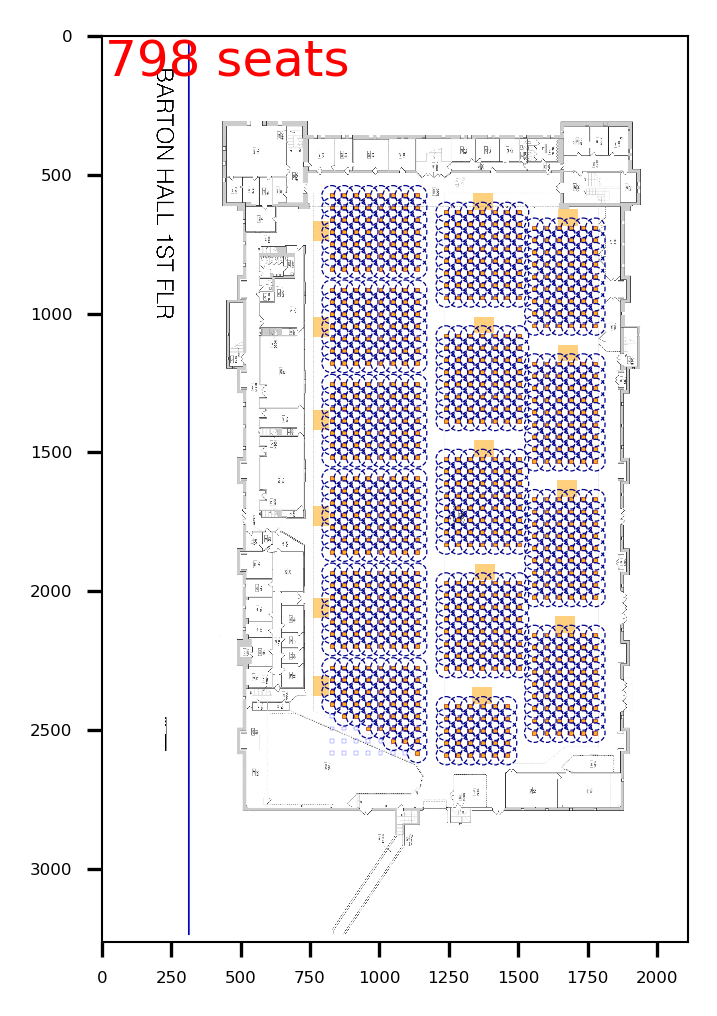

In [24]:
seats = 0
# plot all points to verify the matching worked
#img = plt.imread('drawings/OLH165_solved.jpg') # to see hardcoded solutions
img = cv2.imread(floor)

# set axis tick size
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 
fig, ax = plt.subplots(dpi=300)
#plt.axis('off')
# set axis line size
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
    
for classroom in CLASSROOMS:
    # define a dataframe of Polygons and Points
    df = pd.DataFrame(list(zip(classroom['polys'], classroom['points'])), columns =['polygon', 'point'])

    print('There are %d nodes.' % df.shape[0])
    
    # generate edges from distances
    edgelist = list()      # overall list of (directed) edges

    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            if (i != j):
                dist = df['polygon'][j].distance(df['point'][i])
                if (dist <= feet6):
                    edgelist.append((i,j)) # add edge if seat is too close
    for i in range(df.shape[0]):
        if(df['polygon'][i].intersects(classroom['zone'])):
            edgelist.append((i,i))
        
    for i in range(df.shape[0]):
        for doorway in classroom['doorways']:
            if(df['polygon'][i].intersects(doorway)):
                edgelist.append((i,i))
    print('There are %d edges and %d nodes.' % (len(edgelist), df.shape[0]))
    
    # solve problem
    sol = miset(df.index.values, edgelist, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    # map solution to dataframe
    df['index_string'] = df.index.astype(str) # get index as strings, dict is {'id': val}
    df['in_solution'] = df['index_string'].map(sol)

        
    
    #plot seats
    for i in range(df.shape[0]):
        if (df['in_solution'][i] == 1):
            xs,ys = df['polygon'][i].exterior.xy
            ax.fill(xs, ys, alpha=0.9, fc='orange', ec='darkred', linewidth=0.15, zorder=3)
        else:
            xs,ys=df['polygon'][i].exterior.xy
            ax.plot(xs, ys, color='blue', alpha=0.6, linewidth=0.1, solid_capstyle='round', zorder=2)
    # plot circles
    sol_ids = df[df['in_solution']==1].index.values # get points in solution
    for i in sol_ids:
        draw_circle = plt.Circle((df['point'][i].x, df['point'][i].y), feet6-1, fill=False,ec='darkblue', ls='--', lw=0.3, zorder=4)
        ax.add_artist(draw_circle)
    # plot stick
    x,y = classroom['zone'].exterior.xy
    ax.fill(x, y, alpha=0.5, fc='orange', ec='none', linewidth=0.5, zorder=2)
    for i in sol.values():
        seats += i
plt.text(10, 10, str(int(seats)) + " seats", fontsize=12, color='red', horizontalalignment='left', verticalalignment='top')

ax.imshow(img)
plt.savefig(solution_name+'-grid.jpg',orientation='portrait',format='jpg',dpi=1000)